In [2]:
import cvxpy as cvx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Data initialization

In [5]:
#Generator's parameters
Gen = pd.DataFrame.from_dict({
    'p1': [0.12, 14.80, 89, 1.2, -5.00, 3.00, 28, 200, 40, 40], 
    'p2': [0.17, 16.57, 83, 2.3, -4.24, 6.09, 20, 290, 30, 30],
    'p3': [0.15, 15.55, 100, 1.1, -2.15, 5.69, 30, 190, 30, 30],
    'p4': [0.19, 16.21, 70, 1.1, -3.99, 6.20, 20, 260, 50, 50]}, 
                 orient='index', columns=['a', 'b', 'c', 'd', 'e', 'f', 'Pmin', 'Pmax', 'RU', 'RD']);
#Gen


In [11]:
Data = pd.DataFrame.from_dict({
    'Load':[510,530,516,510,515,544,646,686,741,734,748,760,754,700,686,720,714,761,727,714,618,584,578,544],
    'Wind':[44.1,48.5,65.7,144.9,202.3,317.3,364.4,317.3,271,306.9,424.1,398,487.6,521.9,541.3,560,486.8,372.6,367.4,314.3,316.6,311.4,405.4,470.4]},
     orient='columns')
#Data

In [12]:
T = len(Data.index) #Time scale
Gen_num = len(Gen.index) #Number of generators
VWC = 50 #Value of loss of wind ($/MW h)
#ESS parameters
SOC_0 = 100;
SOC_max = 300;
SOC_min = 0.2*SOC_max
Pd_max = 0.2*SOC_max; #Discharge limits
Pd_min = 0;
Pc_max = 0.2*SOC_max; #Charge limits
Pc_min = 0;
eta_c = 0.95; #Charge efficiency
eta_d = 0.9; #Discharge efficiency
#Wind gen parameters
Pw_min = 0 #Active power limits for wind turbine
Pw_max = Data.loc[:,'Wind'].values 
Pwc_min = 0 #Curtailed power limits for wind turbine
Pwc_max = Data.loc[:,'Wind'].values

# Optimization problem

In [8]:
#Variables
P = cvx.Variable(shape = (Gen_num,T)) #Generated power (g1,g2,g3,g4)
SOC = cvx.Variable(shape = (T,1)) #State of charge
Pd = cvx.Variable(shape = (T,1)) #Discharge power
Pc = cvx.Variable(shape = (T,1)) #Charge power
Pw = cvx.Variable(shape = (T,1)) #Wind power
Pwc = cvx.Variable(shape = (T,1)) #Curtailed power for wind turbine

P_min = Gen.loc[:,'Pmin'].values #Power generation limits
P_max = Gen.loc[:,'Pmax'].values
RU = Gen.loc[:,'RU'].values #RampUp
RD = Gen.loc[:,'RD'].values #RampDown
a = Gen.loc[:,'a'].values #price coefficients
b = Gen.loc[:,'b'].values
c = Gen.loc[:,'c'].values
Pl = Data.loc[:,'Load'].values #Load

Wind = Data.loc[:,'Wind'].values #Available wind power

A = np.eye(Gen_num) #Identity matrix



In [9]:
#Problem description
samples = []
for t in range(T):
    cost = sum(a*A*P[:,t]**2 + b*A*P[:,t] + c) + VWC*Pwc[t] #Generation cost/ objective function
    if t == 0:
        constr = [SOC[t] == SOC_0 + Pc[t]*eta_c - Pd[t]/eta_d] #State of charge
    else:
        constr = [P[:,t] - P[:,t-1] <= RU, #RampUp
                  P[:,t-1] - P[:,t] <= RD, #RampDown
                  SOC[t] == SOC[t-1] + Pc[t]*eta_c - Pd[t]/eta_d #State of charge
                  ]    
        
    constr.extend([SOC[t] >= SOC_min, #Battery's charge limits
                  SOC[t] <= SOC_max,
                  Pd[t] >= Pd_min, #Discharge limits
                  Pd[t] <= Pd_max,
                  Pc[t] >= Pc_min, #Charge limits
                  Pc[t] <= Pc_max, 
                  P[:,t] >= P_min, #Generation limits
                  P[:,t] <= P_max, 
                  Pw[t] >= Pw_min, #Wind power limits
                  Pw[t] <= Pw_max[t],
                  Pwc[t] >= Pwc_min, #Curtailed wind power limits
                  Pwc[t] <= Pwc_max[t],
                  Pw[t] + Pwc[t] <= Wind[t], #Wind balance
                  Pw[t] + sum(P[:,t]) + Pd[t] >= Pl[t] + Pc[t]]) #Power balance
    
    samples.append(cvx.Problem(cvx.Minimize(cost), constr))
prob = sum(samples)

#prob.constraints += [SOC[T-1] == SOC_0]#????
prob.solve(solver=cvx.ECOS_BB)


222947.26667693656

In [10]:
#Values of variables
P_sum = sum(P.value)
P_f = P.value
SOC_f = SOC.value
Pd_f = Pd.value
Pc_f = Pc.value
Pw_f = Pw.value

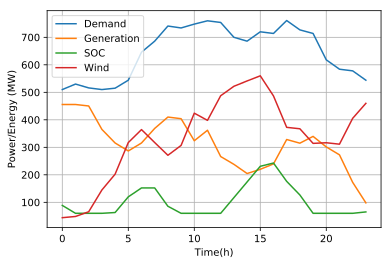

In [19]:
#Power balance plot
plt.figure()
plt.plot(Pl,label="Demand") 
plt.plot(P_sum,label="Generation") 
plt.plot(SOC_f,label="SOC")#,marker = 'o' 
plt.plot(Pw_f,label="Wind")
plt.xlabel('Time(h)')
plt.ylabel('Power/Energy (MW)')
plt.legend(loc='upper left')
plt.grid()
plt.savefig('pic.png')

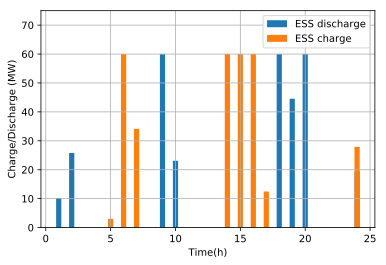

In [24]:
#Charge/Discharge plot
x = range(1,T+1)
plt.figure()
 
plt.bar(x,Pd_f.flatten(),label="ESS discharge", width = 0.4) 
plt.bar(x,Pc_f.flatten(),label="ESS charge", width = 0.4) 
plt.xlabel('Time(h)')
plt.ylabel('Charge/Discharge (MW)')
plt.legend(loc='upper right')
plt.ylim(0,75)
plt.grid()
plt.savefig('pic.png')

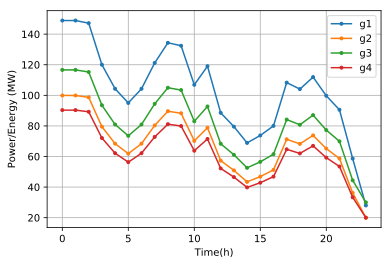

In [26]:
#Generation plan plot
plt.figure()
plt.plot(P_f[0,:],label="g1", marker = '.') 
plt.plot(P_f[1,:],label="g2", marker = '.') 
plt.plot(P_f[2,:],label="g3", marker = '.')
plt.plot(P_f[3,:],label="g4", marker = '.')
plt.xlabel('Time(h)')
plt.ylabel('Power/Energy (MW)')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('pic.png')